<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp2/blob/main/notebooks/create_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

In [2]:
%matplotlib inline
%load_ext autoreload
%load_ext rich
%autoreload 2

In [3]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

### 1. Instalacion de paquetes

In [4]:
if is_runing_into_colab_env(): 
    !pip install rich
    !pip install networkx

###  2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/datasets`.

In [5]:
# Database...
dataset_filename = "SWOW-EN.R100.csv"
dataset_url      = 'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp2/main/datasets/{}.zip'.format(dataset_filename)

# Embeddings...

# Glove:
glove_embeding_filename     = "glove.840B.300d"
glove_embeding_filename_txt = glove_embeding_filename + '.txt'
glove_embeding_url          = 'https://nlp.stanford.edu/data/{}.zip'.format(glove_embeding_filename)

# Google:
google_embeding_filename    = "GoogleNews-vectors-negative300.bin.gz"
google_embeding_url         = 'https://s3.amazonaws.com/dl4j-distribution/{}'.format(google_embeding_filename)


if is_runing_into_colab_env():
    !cd ~
    !rm -rf datasets
    !rm -rf *.zip
    
    !wget  {dataset_url}
    !wget  {glove_embeding_url}
    !wget  {google_embeding_url}
    
    !unzip {dataset_filename}.zip
    !unzip {glove_embeding_filename}.zip
    !mkdir datasets

    !mv {dataset_filename} datasets
    !mv {glove_embeding_filename}.txt datasets
    !mv {google_embeding_filename} datasets

    !rm *.zip

###  3. Importa libreria del proyecto

In [6]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp2'):
        print('Pull...\n')
        !cd dm-cyt-tp2; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp2.git

In [7]:
sys.path.append('/content/dm-cyt-tp2/src' if is_runing_into_colab_env() else '../src')
dataset_path = '/content/datasets/{}' if is_runing_into_colab_env() else '../datasets/{}'

###  4. Importa paquetes externos

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd
import networkx as nx

import logging
from logger import setup_logger

from scipy.spatial.distance import euclidean, jaccard, cosine

from distance import closest, \
                     show_closest, \
                     distance, \
                     distance_to_weight

from step import  select_columns, \
                  rename_columns, \
                  filter_bidiredtional_associations, \
                  filter_words_lt, \
                  filter_stopwords, \
                  to_unique_works, \
                  to_glove_word_embeddings, \
                  lower, \
                  strip, \
                  dropna, \
                  plot_frequency, \
                  log_unique_words, \
                  log_source_into_response_and_vise_versa, \
                  n_top, \
                  all_columns_contains, \
                  append_calculated_column, \
                  append_source_response_freqs, \
                  select, \
                  distinct

from embedding import GoogleW2VSimilarity
from dataset import summary

/home/adrian/.conda/envs/dm-cyt-tp2/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
setup_logger(format = '%(levelname)s: %(message)s')

###  5. Preprocesar dataset

En este paso seleccionamos las columnas **cue** y **R1**, las renombramos a **source** y **response**. Luego minisculizamos y quitamos espacios. Filtramos las palabras de menos de 2 letras, filtramos las filas con nulos. Por último filtramos stop words por varios lenguajes.

In [10]:
def load_dataset(filename): return pd.read_csv(dataset_path.format(filename))

In [11]:
dataset = load_dataset(dataset_filename) \
    .pipe(select_columns) \
    .pipe(rename_columns, {'cue': 'source', 'R1': 'response'}) \
    .pipe(lower) \
    .pipe(strip) \
    .pipe(log_unique_words) \
    .pipe(log_source_into_response_and_vise_versa, unique=True) \
    .pipe(log_source_into_response_and_vise_versa, unique=False) \
    .pipe(filter_words_lt, size_less_than=2) \
    .pipe(dropna) \
    .pipe(filter_stopwords, column = 'source') \
    .pipe(filter_stopwords, column = 'response')

INFO: (1228200, 13) --> select_columns({}) --> (1228200, 2)
INFO: (1228200, 2) --> rename_columns({}) --> (1228200, 2)
INFO: (1228200, 2) --> lower({}) --> (1228200, 2)
INFO: (1228200, 2) --> strip({}) --> (1228200, 2)
INFO: Unique - Source: 12282, Response: 63715
INFO: Unique: True, Source into response: 1104304, Response into source: 1219500
INFO: Unique: False, Source into response: 123896, Response into source: 8700
INFO: (1228200, 2) --> filter_words_lt({'size_less_than': 2}) --> (1225128, 2)
INFO: (1225128, 2) --> dropna({}) --> (1194119, 2)
INFO: (1194119, 2) --> filter_stopwords({'languages': ['arabic']}) --> (1194119, 2)
INFO: (1194119, 2) --> filter_stopwords({'languages': ['azerbaijani']}) --> (1193633, 2)
INFO: (1193633, 2) --> filter_stopwords({'languages': ['bengali']}) --> (1193633, 2)
INFO: (1193633, 2) --> filter_stopwords({'languages': ['danish']}) --> (1191959, 2)
INFO: (1191959, 2) --> filter_stopwords({'languages': ['dutch']}) --> (1190828, 2)
INFO: (1190828, 2) --

###  6. Generar un dicionario de embedding a partir de Glove

A continuacion se genera un diccionario donde la calse es una palabra y el valor es un vector embedding. Ademas solo genermos este doccionario para las palabar que se encuentran en el dataset inicial.

In [12]:
glove_word_embeddings = dataset \
    .pipe(to_unique_works) \
    .pipe(to_glove_word_embeddings, file_path = dataset_path.format(glove_embeding_filename_txt))

INFO: (1135308, 2) --> to_unique_works({}) --> (462916, 1)


  0%|          | 0/462916 [00:00<?, ?it/s]

INFO: Found 5709 words.
INFO: (462916, 1) --> to_glove_word_embeddings({'file_path': '../datasets/glove.840B.300d.txt'}) --> 5709


### 7. Calcular distancias

Vamos a calcular distancias con dos enfoques distintos Usandel enveding de Glove y luego el embedding de GoogleNews. 

### 7.1 Glove

Calculamos la distancias de una palabra elegida al azar contra todas las demas palabras del diccionario. Luego nos quedamos con el top 10 de las palabras mas cercanas.

In [13]:
word_a = list(glove_word_embeddings.keys())[10]
word_b = list(glove_word_embeddings.keys())[11]

show_closest(glove_word_embeddings, word_a, cosine)
show_closest(glove_word_embeddings, word_a, euclidean)
show_closest(glove_word_embeddings, word_a, jaccard)

INFO: - distance: cosine
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'affordable', 'straightforward', 'mainstream', 'sustainable', 'regardless', 'marketplace', 'framework', 'guidelines']
INFO: - distance: euclidean
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'straightforward', 'regardless', 'affordable', 'mainstream', 'mainstay', 'drawback', 'forefront', 'alongside']
INFO: - distance: jaccard
INFO: - Word: alternative
INFO: - Closest: ['jetliner', 'dealbreaker', 'goldeneye', 'shipmate', 'penknife', 'masterbedroom', 'stairstep', 'serverfarm', 'website']


In [14]:
distance(glove_word_embeddings, word_a, word_b, cosine)

0.914529338479042

### 7.1 GoogleNews

Ahora si usamos GoogleNews calcular la similaridad entre las palablas y tambien debemos filtrassr las palabras que no tenga similaridad. esta ultima segan a quellas que no se encuentren en el conjunto de embeddings de GoogleNews.


In [15]:
similarity = GoogleW2VSimilarity( path = dataset_path.format(google_embeding_filename))

INFO: loading projection weights from ../datasets/GoogleNews-vectors-negative300.bin.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from ../datasets/GoogleNews-vectors-negative300.bin.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-12-09T18:43:10.103015', 'gensim': '4.0.1', 'python': '3.9.6 (default, Aug 18 2021, 19:38:01) \n[GCC 7.5.0]', 'platform': 'Linux-5.14.18-1-MANJARO-x86_64-with-glibc2.33', 'event': 'load_word2vec_format'}


In [16]:
similarity.cosine(word_a, word_b)

0.022291513

### 8. Calculamos los pesos para ambos grafos

Calculamos el peso de las asociaciones **source-response** para el grafo **Gsww**:

In [17]:
dataset = dataset \
    .pipe(append_source_response_freqs) \
    .pipe(
        append_calculated_column, 
        lambda it: it['source_response_freq'] / it['source_freq'], 
        column_name='sww_weight'
    )

INFO: (1135308, 2) --> append_source_response_freqs({}) --> (1135308, 4)
INFO: (1135308, 5) --> append_calculated_column({'column_name': 'sww_weight'}) --> (1135308, 5)


Calculamos el peso de las asociaciones **source-response** para el grafo **Gw2v**. Tenemos dso tipos de pesos para el enbedding **GoogleNews** y otro para **Glove**:

In [18]:
google_weight = lambda it: distance_to_weight(similarity.cosine(it.source, it.response))
glove_weight  = lambda it: distance_to_weight(distance(glove_word_embeddings, it.source, it.response, cosine))

In [19]:
dataset = dataset.pipe(append_calculated_column, google_weight,  'w2v_google_weight')

INFO: (1135308, 6) --> append_calculated_column({}) --> (1135308, 6)


In [20]:
dataset.head()

,source,response,source_freq,source_response_freq,sww_weight,w2v_google_weight
0,although,nevertheless,56,1,0.017857,0.395890
1,although,though,56,2,0.035714,0.215972
2,although,though,56,2,0.035714,0.215972
3,although,question,56,1,0.017857,0.908560
4,although,however,56,10,0.178571,0.385063


In [21]:
dataset = dataset.pipe(append_calculated_column, glove_weight,  'w2v_glove_weight')

INFO: (1135308, 7) --> append_calculated_column({}) --> (1135308, 7)


In [22]:
dataset.head()

,source,response,source_freq,source_response_freq,sww_weight,w2v_google_weight,w2v_glove_weight
0,although,nevertheless,56,1,0.017857,0.395890,0.0
1,although,though,56,2,0.035714,0.215972,0.0
2,although,though,56,2,0.035714,0.215972,0.0
3,although,question,56,1,0.017857,0.908560,0.0
4,although,however,56,10,0.178571,0.385063,0.0


Calculamos todas las distancias:

Nos quedamos con las filas para las cuales exista su par (Para (a, b) existe un par (b,a)). Finalmente se grafica la frecuencia de palabras para cada columna. 

In [23]:
dataset = dataset.pipe(filter_bidiredtional_associations)

INFO: (1135308, 7) --> filter_bidiredtional_associations({}) --> (1007174, 7)


Finalmente, guardamos el dataset preprocesador para evitar vovler a procesarlo cada vez:

In [24]:
dataset = dataset \
    .pipe(select, ['source', 'response', 'sww_weight', 'w2v_google_weight', 'w2v_glove_weight']) \
    .pipe(distinct)

INFO: (1007174, 7) --> select({}) --> (1007174, 5)
INFO: (1007174, 5) --> distinct({}) --> (367714, 5)


In [25]:
dataset.to_csv( dataset_path.format('processed_dataset.csv'), index=False)

,source,response,sww_weight,w2v_google_weight,w2v_glove_weight
0,although,nevertheless,0.017857,0.395890,0.0
1,although,though,0.035714,0.215972,0.0
3,although,question,0.017857,0.908560,0.0
4,although,however,0.178571,0.385063,0.0
14,although,even,0.035714,0.477791,0.0


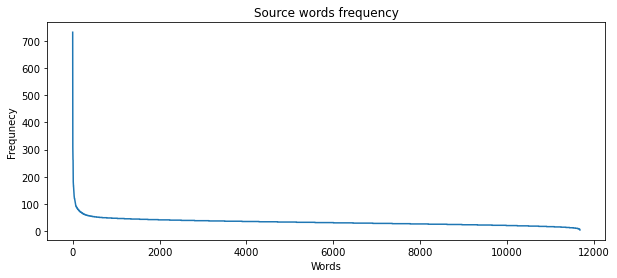

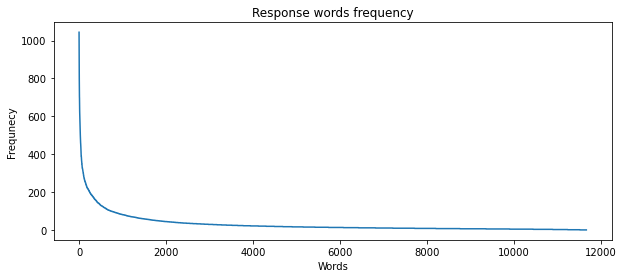

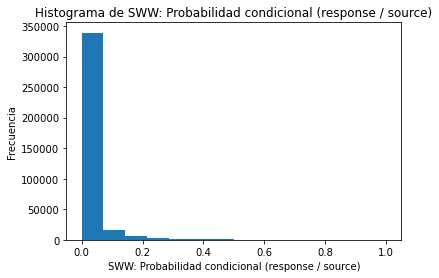

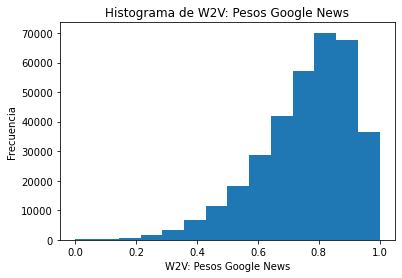

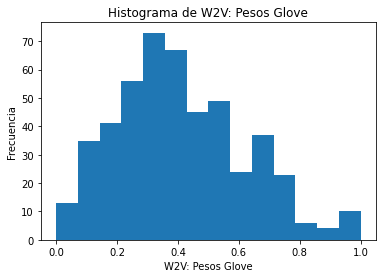

In [27]:
summary(dataset)